# Near-Surface Air Template QA diagnostics

Reference
[MDTF Planning Document](https://docs.google.com/document/d/1P8HqL8O5304qwR3ik9RmgFDwSWwlkPgOjnp39PIkLfY/edit?usp=sharing)

In [1]:
# Development mode: constantly refreshes module code
%load_ext autoreload
%autoreload 2

## Framework Code and Diagnostic Setup

In [2]:
from esnb import CaseGroup, NotebookDiagnostic, RequestedVariable
import os

%matplotlib inline
import warnings

import intake
import intake_esm
import matplotlib
import xarray as xr
import yaml
from matplotlib import pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")
import pandas as pd

pd.set_option("display.max_rows", None)

In [ ]:
%%time

# Define a mode (leave "prod" for now)
mode = "prod"

# Verbosity
verbose = True

# Give your diagnostic a name and a short description
diag_name = "tas QA"
diag_desc = "Near-Surface Air Temperature QA Diagnostics"

# Define what variables you would like to analyze. The first entry is the
# variable name and the second entry is the realm (post-processing dir).
#   (By default, monthly timeseries data will be loaded. TODO: add documentation
#    on how to select different frequencies, multiple realms to search, etc.)

variables = [
    # RequestedVariable("t_ref", "atmos"),
    # RequestedVariable("tos", "ocean_month")
    RequestedVariable("tas", "atmos_cmip"),
]

# Optional: define runtime settings or options for your diagnostic
user_options = {
                "chennai": {"lat": list(map(float, [13])), "lon": list(map(float, [80]))},
                "india": {"lat" : list(map(float, [0, 40])), "lon": list(map(float, [40, 120])) },
                "princeton": {"lat": list(map(float, [40])),"lon": list(map(float,[74])) },
                "date_range": {"start":'1993-01-01',"end": '2022-12-31'}
                }


# Initialize the diagnostic with its name, description, vars, and options
diag = NotebookDiagnostic(diag_name, diag_desc, variables=variables, **user_options)

# Define the groups of experiments to analyze. Provide a single dora id for one experiment
# or a list of IDs to aggregate multiple experiments into one; e.g. historical+future runs
groups = [
    CaseGroup(
        [1188, 1243],
        "time",
        name="ESM4 Historical + Future",
        date_range=("1993-01-01", "2022-12-31"),
        verbose=verbose,
    )
]
# Combine the experiments with the diag request and determine what files need to be loaded:
diag.resolve(groups)

In [4]:
user_options

{'chennai': {'lat': [13.0], 'lon': [80.0]},
 'india': {'lat': [0.0, 40.0], 'lon': [40.0, 120.0]},
 'princeton': {'lat': [40.0], 'lon': [74.0]},
 'date_range': {'start': '1993-01-01', 'end': '2022-12-31'}}

In [ ]:
# Print a list of file paths
# This cell and the markdown cell that follows are necessary to run this notebook
# Interactively on Dora
_ = [print(x) for x in diag.files]

In [37]:
#for testing
#dsdirect = xr.open_mfdataset("/archive/oar.gfdl.bgrp-account/CMIP6/ESM4/ScenarioMIP/ESM4_ssp585_D1/gfdl.ncrc4-intel16-prod-openmp/pp/atmos_cmip/ts/monthly/2yr/*tas.nc"
#                 ,engine="netcdf4")
#dsdirect.tas

<i>(The files above are necessary to run the diagnostic.)</i>

In [8]:
# Dmget the necessary files
diag.dmget()

dmget: All files are online


In [9]:
diag.groups

[CaseGroup <ESM4 Historical + Future>  n_sources=2  resolved=True  loaded=False
   * CaseExperiment ESM4_historical_D1: catalog=True date_range=['1993-01-01', '2022-12-31']
   * CaseExperiment ESM4_ssp585_D1: catalog=True date_range=['1993-01-01', '2022-12-31']]

In [10]:
# Load the data as xarray datasets
diag.load()
# Put all of the xarray datasets into a list

In [11]:
dsets = diag.dsets

In [12]:
diag.groups[0].catalog.df[["variable_id", "experiment_id"]]

,variable_id,experiment_id
0,tas,ESM4_historical_D1
1,tas,ESM4_historical_D1
2,tas,ESM4_historical_D1
3,tas,ESM4_historical_D1
4,tas,ESM4_historical_D1
5,tas,ESM4_historical_D1
6,tas,ESM4_historical_D1
7,tas,ESM4_historical_D1
8,tas,ESM4_historical_D1
9,tas,ESM4_historical_D1


# A snapshot for region=India

In [13]:
# get the custom variable from the diagnostic settings
# Ocean trick - call momgrid on ocean model data to get the static info
varname = diag.variables[0]
areavar = "areacella"
india_lat = diag.diag_vars["india"].get("lat", None)
india_lon = diag.diag_vars["india"].get("lon", None)

In [14]:
for group in groups:
    ds = group.ds[0]

In [15]:
ds.tas

<xarray.DataArray 'tas' (time: 360, lat: 180, lon: 288)> Size: 75MB
dask.array<getitem, shape=(360, 180, 288), dtype=float32, chunksize=(60, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time     (time) object 3kB 1993-01-16 12:00:00 ... 2022-12-16 12:00:00
Attributes:
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: mean
    cell_measures:  area: area
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  air_temperature
    interp_method:  conserve_order2

In [16]:
tas_sel = ds.tas.sel(lat=(slice(india_lat[0],india_lat[1])), lon=slice(india_lon[0],india_lon[1]))

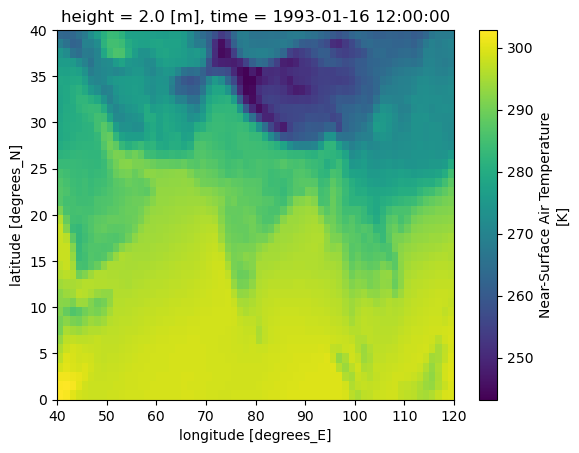

In [17]:
tas_ind = tas_sel.isel(time=0).plot()

# Weighted global time average plot

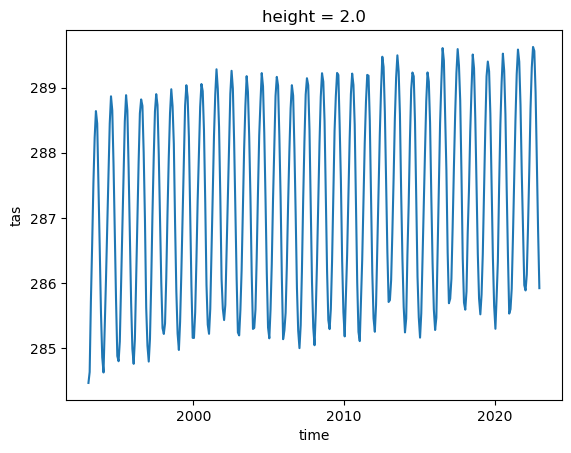

In [18]:
weights = np.cos(np.deg2rad(ds.tas.lat))
weights.name = "weights"
weights
tas_weighted = ds.tas.weighted(weights)
tas_weighted
tas_mean = tas_weighted.mean(("lon", "lat")).plot()

# Montly Climatology and Anomaly (Jan and July)

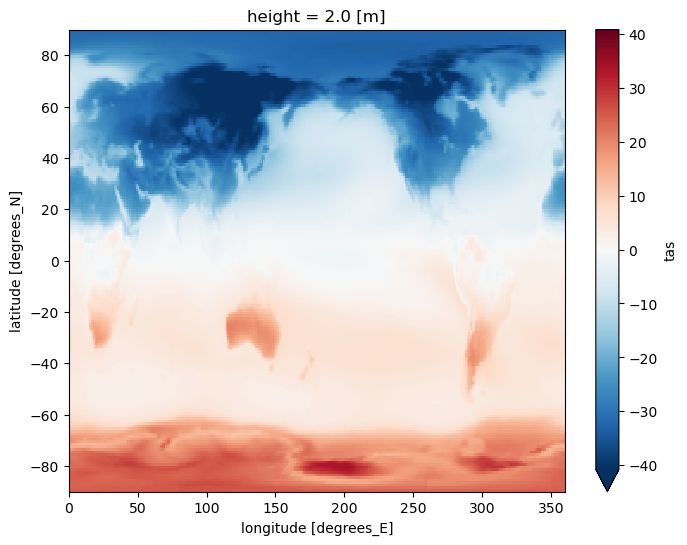

In [19]:
tas_clim = ds.tas.groupby("time.month").mean()
(tas_clim.sel(month=1) - tas_clim.sel(month=7)).plot(size=6, robust=True)

# Seasonal climatology and anomalies

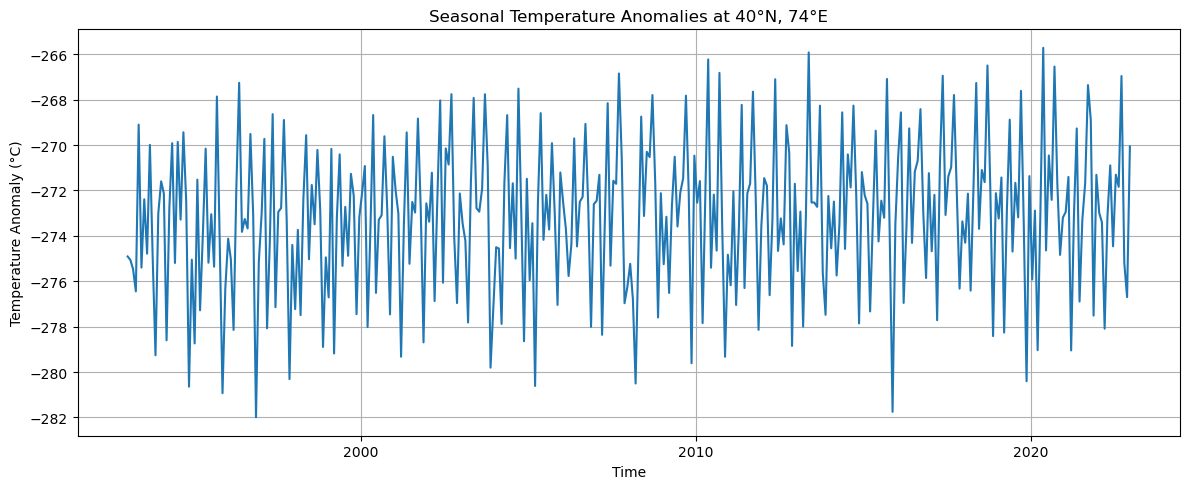

In [20]:
tas_sclim = ds.tas.groupby("time.season").mean()
if (ds.tas.units == 'K'):
    tas_c = ds.tas - 273.15  #  if tas is in Kelvin
tas_season_anom = tas_c.groupby('time.season') - tas_sclim

pctn_lat = diag.diag_vars["princeton"].get("lat", None)
pctn_lon = diag.diag_vars["princeton"].get("lon", None)

tas_anom_point = tas_season_anom.sel(lon=pctn_lon[0], lat=pctn_lat[0], method="nearest")
# Plot time series of anomalies
tas_anom_point.plot(figsize=(12, 5))
plt.title('Seasonal Temperature Anomalies at 40°N, 74°E')
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Seasonal Surface Air Temperature  

In [21]:
#Ref https://docs.xarray.dev/en/latest/examples/monthly-means.html#Now-for-the-heavy-lifting:
month_length = ds.time.dt.days_in_month
# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
tas_weighted = (ds * weights).groupby("time.season").sum(dim="time")

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

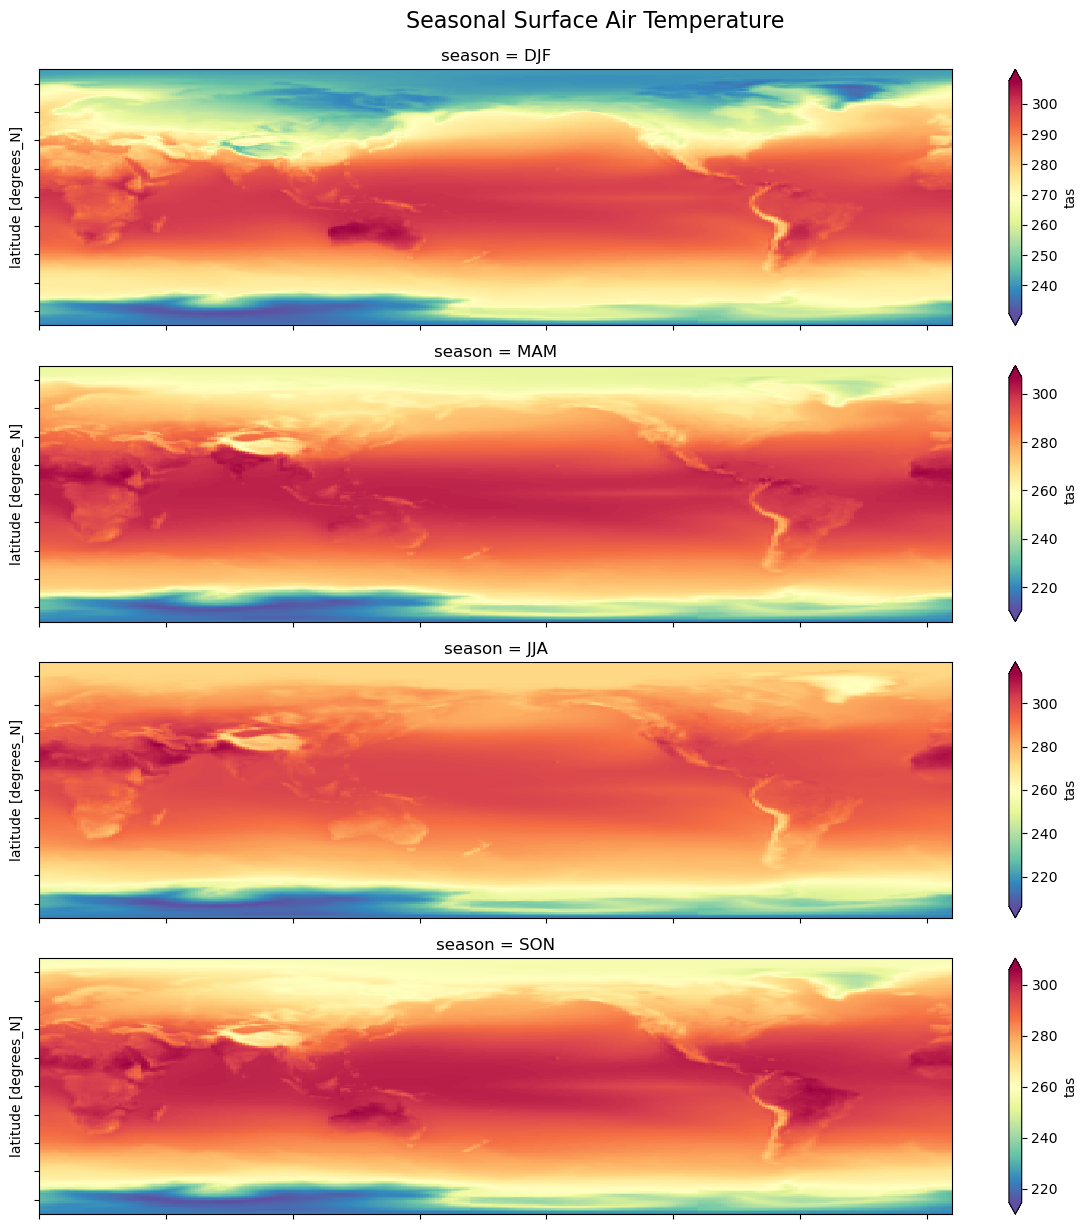

In [22]:
notnull = pd.notnull(tas_weighted["tas"][0])
fig, axes = plt.subplots(nrows=4, figsize=(12,12))

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    tas_weighted['tas'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i], cmap='Spectral_r',
        add_colorbar=True, extend='both')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)


# 3-month and 12-month running mean

## Chennai, South India

Text(0.5, 1.0, 'Rolling 12 and 3 month Mean Surface Air Temperature- Chennai')

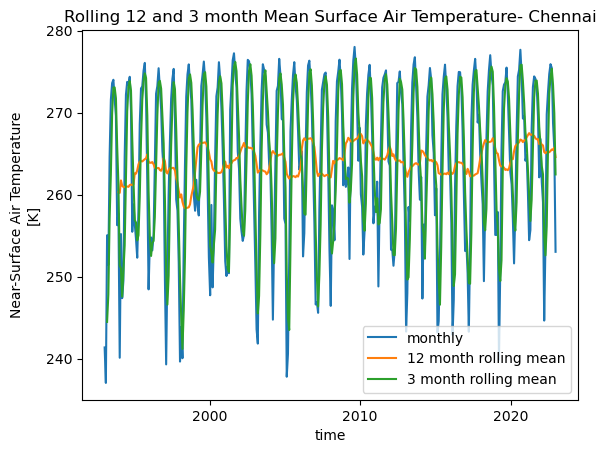

In [23]:
chn_lat = diag.diag_vars["chennai"].get("lat", None)
chn_lon = diag.diag_vars["chennai"].get("lon", None)

t_ref = ds.tas.sel(lon=chn_lat[0], lat=chn_lon[0], method="nearest")
t_ref.plot(label="monthly")
t_ref.rolling(time=12).mean().plot(label="12 month rolling mean")
t_ref.rolling(time=3).mean().plot(label="3 month rolling mean")
plt.legend()
plt.title("Rolling 12 and 3 month Mean Surface Air Temperature- Chennai")

## Princeton, US East coast 

Text(0.5, 1.0, 'Rolling 12 and 3 month mean Surface Air Temperature - Princeton ')

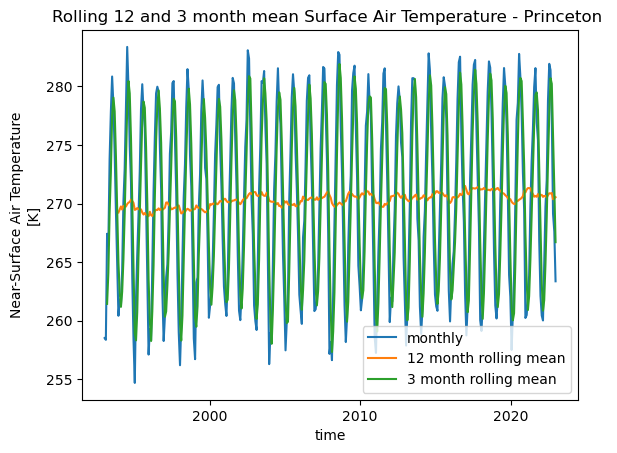

In [24]:
pctn_lat = diag.diag_vars["princeton"].get("lat", None)
pctn_lon = diag.diag_vars["princeton"].get("lon", None)

t_ref = ds.tas.sel(lon=pctn_lon[0], lat=pctn_lat[0], method="nearest")
t_ref.plot(label="monthly")
tref_12mean = t_ref.rolling(time=12).mean()
tref_12mean.plot(label="12 month rolling mean")
t_ref.rolling(time=3).mean().plot(label="3 month rolling mean")
plt.legend()
plt.title("Rolling 12 and 3 month mean Surface Air Temperature - Princeton ")

In [34]:
group.add_metric("Princeton", ("12 month running mean (tas)", tref_12mean.values.tolist()))

In [ ]:
group.metrics

In [36]:
diag.write_metrics()

{
  "DIMENSIONS": {
    "json_structure": [
      "region",
      "model",
      "metric"
    ]
  },
  "RESULTS": {
    "Global": {
      "ESM4 Historical + Future": {
        "Princeton": {
          "12 month running mean (tas)": [
            NaN,
            NaN,
            NaN,
            NaN,
            NaN,
            NaN,
            NaN,
            NaN,
            NaN,
            NaN,
            NaN,
            269.2307434082031,
            269.50640869140625,
            269.75054931640625,
            269.4889221191406,
            269.7956237792969,
            269.72747802734375,
            269.7443542480469,
            269.954833984375,
            270.08001708984375,
            270.1263427734375,
            270.3338623046875,
            270.21868896484375,
            270.0483093261719,
            269.4532775878906,
            269.50390625,
            269.6141357421875,
            269.51763916015625,
            269.49749755859375,
            269.4985